# Stereotype classification

## Inhaltsverzeichnis
1. Einleitung
2. Vorbetrachtung
    - Auswahl der Daten
    - Preselection & Annotation
    - Preprocessing
    - Vorgehen und Ziele
3. Aufgabe 1: Stereotype vs. Keine Stereotype
    - Extraktion der Features für überwachtes Lernen
    - Trainieren und Evaulieren der Modelle
    - Ergebnisse
    - Assoziation zwischen Ngrammen und Labels
        - Ergebnisse
        - Interpretation
4. Aufgabe 2: Opfer vs. Bedrohung
    - Ergebnisse
    - Evaluierung
5. Fazit und Diskussion

## Einführung
Sánchez-Junquera et. al. stellen in ihrer Studie einen neuen Ansatz vor, um Stereotype zu identifizieren. Sie nutzen dafür Frames, das heißt die narrativen Szenarien in denen eine untersuchte Gruppe in öffentlichen Reden platziert wird. Wir stellen diese Experimente mit einem SVM Modell nach und erreichen eine Accuracy von bis zu 0.7.

## Auswahl der Daten
Wir nutzen in dieser Arbeit den Korpus der Plenarprotokolle des Deutschen Bundestages (CPP-BT). Dabei haben wir uns per Aufgabenstellung auf die Periode von 2015 bis 2017 beschränkt. 

Sánchez-Junquera et. al. nutzen den Spanischen Teil des ParlSpeech Korpus (Rauh, Schwalbach 2020). Dabei fokusierten sie sich auf die Perioden von 1996 bis 1998, 2006 bis 2008, und 2016 bis 2018. Laut Sánchez-Junquera et. al. ist eine Besonderheit von ParlSpeech, dass es sich dabei um die Transkription von echten Debatten zwischen revelanten sozialen Akteuren handelt. Zusätzlich mache die Dialog-artige Natur des Korpus ein Herangehen aus der Perspektive der Computerlinguistik schwierig. Diese Dialog-artige Natur besteht zu einem gewissen Grad auch in dem CPP-BT Korpus. Das zeigt sich vor allem bei Zurufen, die des Öfteren passieren. Durch die Zurufe kann es zu Problemen bei der Extrahierung der Sätze kommen, da sie gelegentlich den Redefluss unterbrechen und der Satz vorzeitig beendet wird. Auch die Referenz auf vorherige Redner\*innen kann potentiell zu Problemen führen. 


## Preselection & Annotation

Wir verwenden eine Stichwortliste um den CPP-BT Korpus nach relevanten Reden zu durchsuchen. Wenn eine Rede mehr als 50 Vorkommen von Stichwörtern hat, werden die Sätze extrahiert und für die Annotation verwendet. Es wurden vorerst 500 Sätze von 3 Annotator\*innen annotiert.

Unsere Stichwortliste basiert auf der von Sánchez-Junquera et. al. erstellten Liste an Stichwörtern, allerdings umfasst sie mit 130 Stichwörtern knapp mehr als das doppelte der Stichwörter aus Sánchez-Junquera et. al. Wir haben unsere Stichwortliste mit Stichwörtern aus einzelnen, zufällig ausgewählten Reden welche die 50 Stichwort-Grenze erreicht hatten erweitert. Dabei wurde je eine zufällige Rede aus den Jahren in der Zeitspanne von 2015 bis 2017 genuzt. 

Bei der Erstellung der Annotationsrichtline haben wir uns an der aus Sánchez-Junquera 2021 orientiert. Bei einer erstmaligen Untersuchung wurde klar, dass einige Frames und Kategorien in dem Korpus gar nicht vorkommen und wurden deshalb weggelassen. Das ist spezifisch Kategorie 6: Entmenschlichung. Des Weiteren wurden die Kategorien 4: Gefahr für die Gesellschaft und Kategorie 5: Gefahr für Einzelne zu einer Kategorie zusammengefasst, da es für beide Kategorien bei der ersten Untersuchung weniger Daten gab. Dadurch gibt es 4 verschiedene Kategorien mit insgesamt 22 Frames:
1. Opfer von Xenophoie
2. Leidende Opfer
3. Ökonomische Resource
4. Gefahr

Das sind insgesamt zwei Frames weniger als bei Sánchez-Junquera et. al. Des weiteren wurden Frames auch an den Deutschen Bundestag und Deutschland angepasst. So wird zum Beispiel bei Frame 1.2 vom Vergleich mit Deutschen Auswander\*innen und ehemaligen DDR Bürger\*innen gesprochen, statt vom Vergleich mit Spanischen Personen, die ausgewandert sind.

In [39]:
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import log
from textblob_de import TextBlobDE
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier

In [40]:
pd.set_option('display.max_colwidth', None)

In [41]:
nlp = spacy.load('de_core_news_sm')
de_stopwords = stopwords.words('german')

## Annotierte Daten laden

In [42]:
# Load annotated sentences
raw_df = pd.read_csv("data/combined_samples.csv", sep="\t")
raw_df.drop("Unnamed: 0", axis=1, inplace=True)
raw_df

,Term_NDoc_Date,Sentence,Frame
0,18_100_2015-04-23,Erste Beratung des von der Bundesregierung eingebrachten Entwurfs eines Gesetzes zur Förderung von Investitionen finanzschwacher Kommunen und zur Entlastung von Ländern und Kommunen bei der Aufnahme und Unterbringung von Asylbewerbern Drucksache 18/4653 (neu) ............,x
1,18_100_2015-04-23,Mit dem vorliegenden Entwurf eines Nachtragshaushalts 2015 und dem Entwurf eines Gesetzes zur Förderung von Investitionen finanzschwacher Kommunen und zur Entlastung von Ländern und Kommunen bei der Aufnahme und Unterbringung von Asylbewerbern setzt die Bundesregierung ihre Politik für eine größere Tragfähigkeit der öffentlichen Finanzen und für Wachstum fort.,3
2,18_100_2015-04-23,"Berlin, Donnerstag, den 23. April 2015 9485 Dr. Dietmar Bartsch (A) (C) (D)(B) bereitstellen – auch in Kenntnis der Tatsache, dass die Übergriffe auf Ausländer, auf Unterkünfte der Asylbewerber zugenommen haben und dass Menschen, die im Ehrenamt diese Willkommenskultur, von der wir alle sprechen, leben, eben nicht wenige Probleme haben.",2.1
3,18_100_2015-04-23,"Es ist überhaupt nicht hinnehmbar, wenn der Generalsekretär einer immerhin regierungstragenden Partei, der CSU, sagt, das Asylrecht sei nicht für Sozialtouristen gemacht, die einen Freifahrtschein ins „All-inclusive-Sozialparadies“ buchen wollen.",4.4
4,18_100_2015-04-23,"Denn auch unter dem Gesichtspunkt – Kollege Bartsch hat auf die Flüchtlingsströme hingewiesen –, dass wir in den nächsten Jahren große Anstrengungen unternehmen müssen, um Flüchtlinge aufzunehmen und zu integrieren – Integration ist fast genauso wichtig –, muss die Leistungsbereitschaft der Kommunen gewährleistet sein.",4.1
...,...,...,...
495,18_121_2015-09-10,"Das sind die drei Integrationsaufgaben, die wir haben.",x
496,18_121_2015-09-10,Ich komme jetzt auch zum Thema Fluchtursachenbekämpfung.,x
497,18_121_2015-09-10,"Dass viele Mitbürger in unserem Land angesichts einer solchen Anzahl von Flüchtlingen Ängste haben und sich fragen, wie Bund, Länder und Kommunen die Unterbringung und auch die Integration bewältigen wollen, ist, wie ich glaube, nur allzu verständlich.",4
498,18_121_2015-09-10,"Denn nur wenn es gelingt, gemeinsam mit der Wirtschaft das Potenzial und die Motivation der Menschen, die zu uns kommen, zu nutzen, nur dann wird Integration gelingen.",3


### ***UPDATE MIT NEUEN ANNOTIERTEN DATEN:***

In [43]:
new_raw_df = pd.read_csv("data/new_combined_samples.csv", sep="\t")
new_raw_df.drop("Unnamed: 0", axis=1, inplace=True)
new_raw_df

,Term_NDoc_Date,Sentence,Frame
0,18_100_2015-04-23,Erste Beratung des von der Bundesregierung eingebrachten Entwurfs eines Gesetzes zur Förderung von Investitionen finanzschwacher Kommunen und zur Entlastung von Ländern und Kommunen bei der Aufnahme und Unterbringung von Asylbewerbern Drucksache 18/4653 (neu) ............,x
1,18_100_2015-04-23,Mit dem vorliegenden Entwurf eines Nachtragshaushalts 2015 und dem Entwurf eines Gesetzes zur Förderung von Investitionen finanzschwacher Kommunen und zur Entlastung von Ländern und Kommunen bei der Aufnahme und Unterbringung von Asylbewerbern setzt die Bundesregierung ihre Politik für eine größere Tragfähigkeit der öffentlichen Finanzen und für Wachstum fort.,3
2,18_100_2015-04-23,"Berlin, Donnerstag, den 23. April 2015 9485 Dr. Dietmar Bartsch (A) (C) (D)(B) bereitstellen – auch in Kenntnis der Tatsache, dass die Übergriffe auf Ausländer, auf Unterkünfte der Asylbewerber zugenommen haben und dass Menschen, die im Ehrenamt diese Willkommenskultur, von der wir alle sprechen, leben, eben nicht wenige Probleme haben.",2.1
3,18_100_2015-04-23,"Es ist überhaupt nicht hinnehmbar, wenn der Generalsekretär einer immerhin regierungstragenden Partei, der CSU, sagt, das Asylrecht sei nicht für Sozialtouristen gemacht, die einen Freifahrtschein ins „All-inclusive-Sozialparadies“ buchen wollen.",4.4
4,18_100_2015-04-23,"Denn auch unter dem Gesichtspunkt – Kollege Bartsch hat auf die Flüchtlingsströme hingewiesen –, dass wir in den nächsten Jahren große Anstrengungen unternehmen müssen, um Flüchtlinge aufzunehmen und zu integrieren – Integration ist fast genauso wichtig –, muss die Leistungsbereitschaft der Kommunen gewährleistet sein.",4.1
...,...,...,...
995,18_138_2015-11-24,"Ich spreche jetzt auch über den Bedarf des Personals, der Sprachlehrer, der Ausbilderinnen und Ausbilder in den Sprachkursen.",x
996,18_138_2015-11-24,"Wir können es uns nicht leisten, auch bei der Integration in solche Engpässe zu laufen.",x
997,18_138_2015-11-24,"Das hat auch einen erheblichen Einfluss darauf, wie schnell Flüchtlinge Zugang zu Integrationskursen bekommen.",x
998,18_138_2015-11-24,"Da bedaure ich sehr, dass das BAMF und Sie das integrationspolitische Versprechen, möglichst alle Asylsuchenden, die eine gute Bleibeperspektive haben, in Sprachkurse aufzunehmen, Dr. Reinhard Brandl Deutscher Bundestag – 18.",x


### Klassenverteilung
Wie sich hieraus erschließt, haben wir aus den insgesamt 500 Sätzen 302 Sätze ohne Stereotyp und 198 Sätze mit einem beliebigen Stereotyp erhalten. Das heißt, dass es im ungefähren Verhältnis 3:2 mehr Sätze ohne Stereotyp gibt als mit.

In [44]:
# Number of sentences labeled with "x"
sum(raw_df["Frame"] == "x")

302

In [45]:
# Number of sentences labeled with a frame or a category
sum(raw_df["Frame"] != "x")

198

### ***UPDATE MIT NEUEN ANNOTIERTEN DATEN:***

In [46]:
# Number of sentences labeled with "x"
sum(new_raw_df["Frame"] == "x")

626

In [47]:
# Number of sentences labeled with a frame or a category
sum(new_raw_df["Frame"] != "x")

374

Die Klassenverteilung bleibt auch nach Hinzufügen der neuen annotierten Daten in etwa gleich. Das Verhältnis verschiebt sich leicht zugunsten der mit einem Frame bzw. einer Kategorie gelabelten Aussagen.

## Preprocessing 
Für den Schritt des Preprocessing haben wir die Sätze tokenisiert, die Groß- und Kleinschreibung einheitlich gemacht indem alle tokens als lowercase gespeichert wurden, und die Punktuation und Stoppwörter entfernt. Beim Vorgehen haben wir uns an Sánchez-Junquera et.al. orientiert.

In [48]:
def preprocess(sent):
    """Takes a sentence, tokenizes it, converts it to lower, removes punctuation and stopwords"""
    # Tokenize
    doc = nlp(sent)
    tokens = [token.text for token in doc]
    # To lower
    tokens_lower = [t.lower() for t in tokens]
    # Remove punctuation and stopwords
    clean = [t for t in tokens_lower if t.isalpha() and t not in de_stopwords]
    return " ".join(clean)


def apply_preprocessing(sents):
    """Takes an array/a list of sentences and applies preprocess() to all sentences"""
    clean_sents = []
    for sent in sents:
        clean_sents.append(preprocess(sent))
    return np.array(clean_sents)

In [49]:
raw_sents = raw_df["Sentence"].to_numpy()
# Preprocess
sents = apply_preprocessing(raw_sents)
sents.size

500

### ***UPDATE MIT NEUEN ANNOTIERTEN DATEN:***

In [50]:
new_raw_sents = new_raw_df["Sentence"].to_numpy()
# Preprocess
new_sents = apply_preprocessing(new_raw_sents)
new_sents.size

1000

## Vorgehen & Ziele
Sánchez-Junquera et al. untersuchen in ihrem Paper, wie effektiv klassische ML-Modelle und SOA-Modelle mithilfe der erstellten Taxonomie und des darauf basierenden annotierten Korpus das Framing von Migrant\*innen klassifizieren können. Dabei werden zwei binäre Klassifikationsprobleme betrachtet:
- Enthält eine Aussage Stereotype über Migrant\*innen oder nicht? ("Stereotype vs. Nonstereotype")
- Angenommen, die Aussage enthält Stereotype: Werden Migrant\*innen als Opfer oder Bedrohung dargestellt? ("Victim vs. Threat")

Wir führen diese Aufgaben mit einem klassischen ML-Modell für überwachtes Lernen, der Support Vector Machine, durch. Wir nutzen, wie die Autor\*innen des Papers, die Implementation von Scikit-learn. Sánchez-Junquera et al. trainieren die Modelle mit der tfidf-gewichteten Bag-of-words Repräsentation der Sätze. Es werden Unigramme, Bigramme und Trigramme verwendet, wobei Unigramme die besten Ergebnisse erzielen.
Im Rahmen dieses Projektes nutzen wir ebenfalls die Bag-of-words Repräsentation, wobei wir das Modell sowohl mit tfidf-Gewichtung als auch ohne tfidf-Gewichtung trainieren. Außerdem testen wir Sentiment als Feature. 

Ziel des Projektes ist es nicht, eine möglichst hohe Performanz der Modelle zu erreichen. Es geht eher darum, die Methode von Sánchez-Junquera et al. explorativ für einen deutschen Korpus nachzubilden. Ist bei einem klassischen ML-Modell, wie der Support-Vector-Machine ein Lerneffekt erkennbar oder basiert die Klassifizierung mehr auf Zufall und geht nicht tatsächlich signifikant über die Accuracy einer Majority Baseline hinaus? Wie gut eignen sich triviale lexikalische Features für das Training? Ist eine Sentimentanalyse hilfreich? Was sagen uns Konfusionsmatrix etc.?

In [51]:
# Array with original indexes so we can retrieve raw sentences later
orig_indexes = np.arange(raw_sents.size)
orig_indexes.size

500

### ***UPDATE MIT NEUEN ANNOTIERTEN DATEN:***

In [52]:
# Array with original indexes so we can retrieve raw sentences later
new_orig_indexes = np.arange(new_raw_sents.size)
new_orig_indexes.size

1000

## 1. Aufgabe: Stereotype vs. Keine Stereotype
Die Arbeit von Sánchez-Junquera et al. hebt sich von vorangegangenen Arbeiten zur automatischen Identifizierung von Stereotypen (über Migrant\*innen) dadurch ab, dass sie das Framing von von Migrant\*innen ins Zentrum rückt. Dies soll ermöglichen auch subtile Stereotypisierungen zu berücksichtigen, die nicht durch die Kategorie "Migrant\*innen werden wörtlich negative Attribute zugeschrieben" erfasst werden. Das Augenmerkt der ersten Klassifikationsaufgabe liegt also darin, die Modelle in Hinblick auf ihre Fähigkeit, subtile Stereotype zu erkennen, zu bewerten.

Die Annotator\*innen wurden gebeten, die Aussagen über Migrant\*innen Frames zuzuordnen. Sánchez-Junquera et al. erheben den Anspruch, dass die Taxonomie von Frames, vollständig die Dimensionen der Stereotypisierung von Migrant\*innen abbildet, sei sie positiv oder negativ. Alle Sätze, denen ein Frame oder eine Kategorie zugeordnet wurde, enthalten also laut Sánchez-Junquera et al. Stereotype.
Sätze, welche keinem Frame oder keiner Kategorie zugeordnet werden konnten, sollten mit "x" annotiert werden. 

Dem Datensatz wird eine Spalte "Contains stereotypes" mit den Goldlabels für die Klassifikation hinzugefügt. Sätze, welche mit "x" annotiert wurden, erhalten das Label "0" für "enthält keine Stereotype". Alle anderen Sätze erhalten "1" als Label.

In [53]:
def get_binary_labels(data):
    """Add column to df with binary labels for classification"""
    data.loc[data["Frame"] == "x", "Contains stereotypes"] = 0
    data.loc[data["Frame"] != "x", "Contains stereotypes"] = 1
    return data

In [54]:
df = get_binary_labels(raw_df)
df.head()

,Term_NDoc_Date,Sentence,Frame,Contains stereotypes
0,18_100_2015-04-23,Erste Beratung des von der Bundesregierung eingebrachten Entwurfs eines Gesetzes zur Förderung von Investitionen finanzschwacher Kommunen und zur Entlastung von Ländern und Kommunen bei der Aufnahme und Unterbringung von Asylbewerbern Drucksache 18/4653 (neu) ............,x,0.0
1,18_100_2015-04-23,Mit dem vorliegenden Entwurf eines Nachtragshaushalts 2015 und dem Entwurf eines Gesetzes zur Förderung von Investitionen finanzschwacher Kommunen und zur Entlastung von Ländern und Kommunen bei der Aufnahme und Unterbringung von Asylbewerbern setzt die Bundesregierung ihre Politik für eine größere Tragfähigkeit der öffentlichen Finanzen und für Wachstum fort.,3,1.0
2,18_100_2015-04-23,"Berlin, Donnerstag, den 23. April 2015 9485 Dr. Dietmar Bartsch (A) (C) (D)(B) bereitstellen – auch in Kenntnis der Tatsache, dass die Übergriffe auf Ausländer, auf Unterkünfte der Asylbewerber zugenommen haben und dass Menschen, die im Ehrenamt diese Willkommenskultur, von der wir alle sprechen, leben, eben nicht wenige Probleme haben.",2.1,1.0
3,18_100_2015-04-23,"Es ist überhaupt nicht hinnehmbar, wenn der Generalsekretär einer immerhin regierungstragenden Partei, der CSU, sagt, das Asylrecht sei nicht für Sozialtouristen gemacht, die einen Freifahrtschein ins „All-inclusive-Sozialparadies“ buchen wollen.",4.4,1.0
4,18_100_2015-04-23,"Denn auch unter dem Gesichtspunkt – Kollege Bartsch hat auf die Flüchtlingsströme hingewiesen –, dass wir in den nächsten Jahren große Anstrengungen unternehmen müssen, um Flüchtlinge aufzunehmen und zu integrieren – Integration ist fast genauso wichtig –, muss die Leistungsbereitschaft der Kommunen gewährleistet sein.",4.1,1.0


In [55]:
# Get goldlabels
y = df["Contains stereotypes"].to_numpy()

### ***UPDATE MIT NEUEN ANNOTIERTEN DATEN:***

In [56]:
new_df = get_binary_labels(new_raw_df)
new_y = new_df["Contains stereotypes"].to_numpy()
new_df.head()

,Term_NDoc_Date,Sentence,Frame,Contains stereotypes
0,18_100_2015-04-23,Erste Beratung des von der Bundesregierung eingebrachten Entwurfs eines Gesetzes zur Förderung von Investitionen finanzschwacher Kommunen und zur Entlastung von Ländern und Kommunen bei der Aufnahme und Unterbringung von Asylbewerbern Drucksache 18/4653 (neu) ............,x,0.0
1,18_100_2015-04-23,Mit dem vorliegenden Entwurf eines Nachtragshaushalts 2015 und dem Entwurf eines Gesetzes zur Förderung von Investitionen finanzschwacher Kommunen und zur Entlastung von Ländern und Kommunen bei der Aufnahme und Unterbringung von Asylbewerbern setzt die Bundesregierung ihre Politik für eine größere Tragfähigkeit der öffentlichen Finanzen und für Wachstum fort.,3,1.0
2,18_100_2015-04-23,"Berlin, Donnerstag, den 23. April 2015 9485 Dr. Dietmar Bartsch (A) (C) (D)(B) bereitstellen – auch in Kenntnis der Tatsache, dass die Übergriffe auf Ausländer, auf Unterkünfte der Asylbewerber zugenommen haben und dass Menschen, die im Ehrenamt diese Willkommenskultur, von der wir alle sprechen, leben, eben nicht wenige Probleme haben.",2.1,1.0
3,18_100_2015-04-23,"Es ist überhaupt nicht hinnehmbar, wenn der Generalsekretär einer immerhin regierungstragenden Partei, der CSU, sagt, das Asylrecht sei nicht für Sozialtouristen gemacht, die einen Freifahrtschein ins „All-inclusive-Sozialparadies“ buchen wollen.",4.4,1.0
4,18_100_2015-04-23,"Denn auch unter dem Gesichtspunkt – Kollege Bartsch hat auf die Flüchtlingsströme hingewiesen –, dass wir in den nächsten Jahren große Anstrengungen unternehmen müssen, um Flüchtlinge aufzunehmen und zu integrieren – Integration ist fast genauso wichtig –, muss die Leistungsbereitschaft der Kommunen gewährleistet sein.",4.1,1.0


### Extraktion von Features für überwachtes Lernen
#### 1. Bag-of-Ngrams ohne Tfidf-Gewichtung
Zunächst wandeln wir den Datensatz in seine Bag-of-words bzw. "Bag-of-ngrams" Repräsentation um. Jeder Satz wird also als Vektor dargestellt, dessen Werte die Counts aller im Datensatz vorkommenden Ngramme darstellen.

In [57]:
def get_ngram_count_matrx(sents, n):
    """Get ngrams and ngram count matrix"""
    vectorizer = CountVectorizer(ngram_range=(n, n))
    ngram_count_matrx = vectorizer.fit_transform(sents).toarray()
    ngrams = vectorizer.get_feature_names_out()
    return ngrams, ngram_count_matrx

In [58]:
unigrams, unigram_count_matrx = get_ngram_count_matrx(sents, 1)
bigrams, bigram_count_matrx = get_ngram_count_matrx(sents, 2)
trigrams, trigram_count_matrx = get_ngram_count_matrx(sents, 3)

In [59]:
# Number of unique unigrams, bigrams and trigrams
unigrams.size, bigrams.size, trigrams.size

(2457, 4371, 4091)

In [60]:
unigram_count_matrx.shape, bigram_count_matrx.shape, trigram_count_matrx.shape

((500, 2457), (500, 4371), (500, 4091))

### ***UPDATE MIT NEUEN ANNOTIERTEN DATEN:***

In [61]:
new_unigrams, new_unigram_count_matrx = get_ngram_count_matrx(new_sents, 1)
new_bigrams, new_bigram_count_matrx = get_ngram_count_matrx(new_sents, 2)
new_trigrams, new_trigram_count_matrx = get_ngram_count_matrx(new_sents, 3)

new_unigrams.size, new_bigrams.size, new_trigrams.size

(4088, 8651, 8222)

#### 2. Bag-of-ngrams mit Tfidf-Gewichtung
Nun ziehen wir das Tfidf-Maß hinzu, um die Counts der Ngramme zu gewichten.

In [62]:
# Add weighing with tfidf
def transform_to_tfidf(ngram_count_matrx):
    """Takes count matrix and transforms matrix based on tfidf"""
    transformer = TfidfTransformer()
    tfidf_matrx = transformer.fit_transform(ngram_count_matrx).toarray()
    return tfidf_matrx

In [63]:
unigram_tfidf_matrx = transform_to_tfidf(unigram_count_matrx)
bigram_tfidf_matrx = transform_to_tfidf(bigram_count_matrx)
trigram_tfidf_matrx = transform_to_tfidf(trigram_count_matrx)

In [64]:
unigram_tfidf_matrx.shape, bigram_tfidf_matrx.shape, trigram_tfidf_matrx.shape

((500, 2457), (500, 4371), (500, 4091))

### ***UPDATE MIT NEUEN ANNOTIERTEN DATEN:***

In [65]:
new_unigram_tfidf_matrx = transform_to_tfidf(new_unigram_count_matrx)
new_bigram_tfidf_matrx = transform_to_tfidf(new_bigram_count_matrx)
new_trigram_tfidf_matrx = transform_to_tfidf(new_trigram_count_matrx)

new_unigram_tfidf_matrx.shape, new_bigram_tfidf_matrx.shape, new_trigram_tfidf_matrx.shape

((1000, 4088), (1000, 8651), (1000, 8222))

#### 3. Sentiment Scores
Als letztes berechnen wir für jeden Satz noch den Sentiment score. Dafür nutzen wir das Package TextBlobDE.

In [66]:
def get_sentiment(sents):
    """Takes an array/ a list of senteences and returns an array of corresponding polarity scores"""
    sentiment = []
    for sent in sents:
        blob = TextBlobDE(sent)
        sentiment.append(blob.polarity)
    return np.array(sentiment)

In [67]:
sentiment_scores = get_sentiment(sents).reshape(-1, 1)
sentiment_scores.shape

(500, 1)

### ***UPDATE MIT NEUEN ANNOTIERTEN DATEN:***

In [68]:
new_sentiment_scores = get_sentiment(new_sents).reshape(-1, 1)
new_sentiment_scores.shape

(1000, 1)

In [69]:
# Create dicts with features
name2ngram_counts = {
    "Unigram counts": unigram_count_matrx,
    "Bigram counts": bigram_count_matrx, 
    "Trigram counts": trigram_count_matrx
}
name2ngram_tfidf = {
    "Unigram Tfidf": unigram_tfidf_matrx,
    "Bigram Tfidf": bigram_tfidf_matrx,
    "Trigram Tfidf": trigram_tfidf_matrx
}

### ***UPDATE MIT NEUEN ANNOTIERTEN DATEN:***

In [70]:
# Create new dicts with features
new_name2ngram_counts = {
    "Unigram counts": new_unigram_count_matrx,
    "Bigram counts": new_bigram_count_matrx, 
    "Trigram counts": new_trigram_count_matrx
}
new_name2ngram_tfidf = {
    "Unigram Tfidf": new_unigram_tfidf_matrx,
    "Bigram Tfidf": new_bigram_tfidf_matrx,
    "Trigram Tfidf": new_trigram_tfidf_matrx
}

### Trainieren und Evaluieren der Modelle

**Majority Baseline:**

Als Baseline verwenden wir eine Majority Baseline, d.h. es wird immer die häufigste Kategorie vorhergesagt. Sie hat eine Accuracy von 0.604.

In [71]:
# Train baseline
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(sents, y)
acc = dummy_clf.score(sents,y)
print(f"Accuracy of majority baseline: {acc}")

Accuracy of majority baseline: 0.604


### ***UPDATE MIT NEUEN ANNOTIERTEN DATEN:***

In [72]:
# Train baseline
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(new_sents, new_y)
acc = dummy_clf.score(new_sents,new_y)
print(f"Accuracy of majority baseline: {acc}")

Accuracy of majority baseline: 0.626


In [78]:
def train_model(X, y, orig_indexes, model):
    """
    Takes data, goldlabels, list of original indexes from raw data and a classifier model,
    splits the data into training and test set, fits the model to the training data and returns
    the goldlabels for testing, the labels predicted by the model and an array of original indexes
    to retrieve raw sentences corresponding to the predicted labels
    """
    # Split into training and test data
    X_train, X_test, y_train, y_test, orig_train, orig_test = train_test_split(
    X, y, orig_indexes,
    test_size=0.2, 
    stratify=y, 
    random_state=10
    )
    # Fit model
    model.fit(X_train, y_train)
    # Make predictions
    y_pred = model.predict(X_test)
    
    return y_test, y_pred, orig_test

def get_predictions(raw_sents, y_test, y_pred, orig_test):
    """Create dataframe with raw sents of test set and predictions from model"""
    predictions = []
    for i in range(len(y_pred)):
        predictions.append([raw_sents[orig_test[i]], y_pred[i], y_test[i]])
    predictions_df = pd.DataFrame(predictions, columns=["Raw sentence", "Predicted label", "Gold label"])
    
    return predictions_df

In [74]:
def get_correct(predictions):
    """Returns subset of correct predictions"""
    return predictions.loc[predictions["Predicted label"] == predictions["Gold label"]]

def get_wrong(predictions):
    """Returns subset of wrong predictions"""
    return predictions.loc[predictions["Predicted label"] != predictions["Gold label"]]

In [79]:
def print_results(feature_dict, goldlabels, index_list, raw_sents):
    """
    Takes a dict containing names of features used for training as keys and training data as values,
    call train_model for all these features and print classification report
    """
    for name, features in feature_dict.items():
        y_test, y_pred, orig_test = train_model(features, goldlabels, index_list, SVC())
        predictions = get_predictions(raw_sents, y_test, y_pred, orig_test)
        print(f"{name}:")
        print(classification_report(y_test, y_pred, zero_division=0))
        print("\n")

### Ergebnisse

**1. Bag-of-ngrams ohne Tfidf-Gewichtung:**

Die Accuracy ist bei allen Ergebnissen außer bei Bigrammen höher als die Baseline. Am besten hat das Unigram Modell mit einer Accuracy von 0.62 abgeschnitten. Allerdings ist fraglich ob die Verbesserung um lediglich 0.02 im Falle des Unigramm Modells im Vergleich zur Baseline statistisch signifikant ist.

Der F1 score zeigt, dass Kategorie 0 bei allen Modellen bevorzugt vorhergesagt wird. 

In [80]:
print_results(name2ngram_counts, y, orig_indexes, raw_sents)

Unigram counts:
              precision    recall  f1-score   support

         0.0       0.62      0.93      0.75        60
         1.0       0.60      0.15      0.24        40

    accuracy                           0.62       100
   macro avg       0.61      0.54      0.49       100
weighted avg       0.61      0.62      0.54       100



Bigram counts:
              precision    recall  f1-score   support

         0.0       0.61      0.95      0.74        60
         1.0       0.50      0.07      0.13        40

    accuracy                           0.60       100
   macro avg       0.55      0.51      0.44       100
weighted avg       0.56      0.60      0.50       100



Trigram counts:
              precision    recall  f1-score   support

         0.0       0.61      0.97      0.75        60
         1.0       0.60      0.07      0.13        40

    accuracy                           0.61       100
   macro avg       0.61      0.52      0.44       100
weighted avg       0.61

### ***UPDATE MIT NEUEN ANNOTIERTEN DATEN:***

In [81]:
print_results(new_name2ngram_counts, new_y, new_orig_indexes, new_raw_sents)

Unigram counts:
              precision    recall  f1-score   support

         0.0       0.64      0.97      0.77       125
         1.0       0.64      0.09      0.16        75

    accuracy                           0.64       200
   macro avg       0.64      0.53      0.47       200
weighted avg       0.64      0.64      0.54       200



Bigram counts:
              precision    recall  f1-score   support

         0.0       0.62      0.99      0.77       125
         1.0       0.00      0.00      0.00        75

    accuracy                           0.62       200
   macro avg       0.31      0.50      0.38       200
weighted avg       0.39      0.62      0.48       200



Trigram counts:
              precision    recall  f1-score   support

         0.0       0.62      1.00      0.77       125
         1.0       0.00      0.00      0.00        75

    accuracy                           0.62       200
   macro avg       0.31      0.50      0.38       200
weighted avg       0.39

Mit den neuen annotierten Daten ist Verwendung der Bi- und Trigramme als Features erkennbar, dass das Modell keinen Lerneffekt erzielt. Der Recall für das Label 1 beträgt bei beiden Versuchen 0.0, das Modell sagt also nie Label 1 voraus. Bei den Unigrammen zeigt sich auch kein signifikanter Unterschied mit den neuen annotierten Daten. Unigramme weisen jedoch immer noch die beste Performanz auf. Allerdings ist immer noch fraglich, ob es einen Lerneffekt gegeben hat oder es sich um puren Zufall handelte.

**2. Bag-of-ngrams mit Tfidf-Gewichtung:**

Das Unigram Modell hat wieder die besten Ergebnisse, allerdings ist der macro F1 score mit 0.43 niedriger als bei dem Modell ohne Tfidf-Gewichtung. Mit einem F1 score von 0.00 für Kategorie 1 sind die Bi- und Trigramm Modelle schlechter als die Modelle ohne Tfidf-Gewichtung. Des Weiteren schaffen sie es nicht, die Accuracy der Baseline zu überbieten. Auch hier ist fraglich, ob die Verbesserung vom Unigramm Modell statistisch signifikant ist. Insgesamt schneiden alle Modelle schlechter ab als die Modelle ohne Tfidf-Gewichtung.

In [82]:
print_results(name2ngram_tfidf, y, orig_indexes, raw_sents)

Unigram Tfidf:
              precision    recall  f1-score   support

         0.0       0.61      1.00      0.76        60
         1.0       1.00      0.05      0.10        40

    accuracy                           0.62       100
   macro avg       0.81      0.53      0.43       100
weighted avg       0.77      0.62      0.49       100



Bigram Tfidf:
              precision    recall  f1-score   support

         0.0       0.60      1.00      0.75        60
         1.0       0.00      0.00      0.00        40

    accuracy                           0.60       100
   macro avg       0.30      0.50      0.37       100
weighted avg       0.36      0.60      0.45       100



Trigram Tfidf:
              precision    recall  f1-score   support

         0.0       0.60      1.00      0.75        60
         1.0       0.00      0.00      0.00        40

    accuracy                           0.60       100
   macro avg       0.30      0.50      0.37       100
weighted avg       0.36   

### ***UPDATE MIT NEUEN ANNOTIERTEN DATEN:***

In [83]:
print_results(new_name2ngram_tfidf, new_y, new_orig_indexes, new_raw_sents)

Unigram Tfidf:
              precision    recall  f1-score   support

         0.0       0.63      0.98      0.77       125
         1.0       0.67      0.05      0.10        75

    accuracy                           0.64       200
   macro avg       0.65      0.52      0.43       200
weighted avg       0.65      0.64      0.52       200



Bigram Tfidf:
              precision    recall  f1-score   support

         0.0       0.62      1.00      0.77       125
         1.0       0.00      0.00      0.00        75

    accuracy                           0.62       200
   macro avg       0.31      0.50      0.38       200
weighted avg       0.39      0.62      0.48       200



Trigram Tfidf:
              precision    recall  f1-score   support

         0.0       0.62      1.00      0.77       125
         1.0       0.00      0.00      0.00        75

    accuracy                           0.62       200
   macro avg       0.31      0.50      0.38       200
weighted avg       0.39   

Mit den neuen annotierten Daten weist die Verwendung des TF-IDF-Maßes als Feature leicht bessere Ergebnisse auf, allerdings sind diese ebenfalls als nicht besonders positiv zu bewerten. Erst mit dieser "Verbesserung" erreicht das Modell für Bi- und Trigramme die Baseline (vorher waren die Ergebnisse sogar unter der Baseline). Interessanterweise bewirken Unigramme immer noch die beste Performanz. Auch wenn die statistische Signifikanz zu hinterfragen ist, zeigt sich hier also eine Kontinuität in den Ergebnissen.

**3. Sentiment:**

Das Modell mit nur Sentiment ist genau so gut wie die Bi- und Trigram Modelle mit tfidf-Gewichtung. 

In [84]:
y_test, y_pred, orig_test = train_model(sentiment_scores, y, orig_indexes, SVC())
predictions = get_predictions(raw_sents, y_test, y_pred, orig_test)
print("Sentiment:")
print(classification_report(y_test, y_pred, zero_division=0))

Sentiment:
              precision    recall  f1-score   support

         0.0       0.60      1.00      0.75        60
         1.0       0.00      0.00      0.00        40

    accuracy                           0.60       100
   macro avg       0.30      0.50      0.37       100
weighted avg       0.36      0.60      0.45       100



### ***UPDATE MIT NEUEN ANNOTIERTEN DATEN:***

In [86]:
y_test, y_pred, orig_test = train_model(new_sentiment_scores, new_y, new_orig_indexes, SVC())
predictions = get_predictions(new_raw_sents, y_test, y_pred, orig_test)
print("Sentiment:")
print(classification_report(y_test, y_pred, zero_division=0))

Sentiment:
              precision    recall  f1-score   support

         0.0       0.62      0.95      0.75       125
         1.0       0.33      0.04      0.07        75

    accuracy                           0.61       200
   macro avg       0.48      0.50      0.41       200
weighted avg       0.51      0.61      0.50       200



Mit den neuen annotierten Daten beträgt der Recall für das Label 1 nicht mehr 0.0. und die F1-Scores (Macro und gewichtet) verbessert sich dadurch sichtlich. Trotzdem bleibt die Accuracy unter der Baseline.

**4. Kombinationen von Features:**

Wir testen außerdem, ob eine Kombinationen von unterschiedlichen Features eine Verbesserung der Performance bewirkt.

In [87]:
def combine_features(*features):
    """Concatenate different training data (from different features)"""
    return np.concatenate(features, axis=1)

In [88]:
unigrams_sentiment = combine_features(unigram_count_matrx, sentiment_scores)
bigrams_sentiment = combine_features(bigram_count_matrx, sentiment_scores)
trigrams_sentiment = combine_features(trigram_count_matrx, sentiment_scores)

In [89]:
name2ngrams_sentiment = {
    "Unigram counts + Sentiment": unigrams_sentiment,
    "Bigram counts + Sentiment": bigrams_sentiment,
    "Trigram counts + Sentiment": trigrams_sentiment
}

### ***UPDATE MIT NEUEN ANNOTIERTEN DATEN:***

In [91]:
new_unigrams_sentiment = combine_features(new_unigram_count_matrx, new_sentiment_scores)
new_bigrams_sentiment = combine_features(new_bigram_count_matrx, new_sentiment_scores)
new_trigrams_sentiment = combine_features(new_trigram_count_matrx, new_sentiment_scores)

new_name2ngrams_sentiment = {
    "Unigram counts + Sentiment": new_unigrams_sentiment,
    "Bigram counts + Sentiment": new_bigrams_sentiment,
    "Trigram counts + Sentiment": new_trigrams_sentiment
}

**Bag-of-ngrams + Sentiment:**

Das kombinierte Unigram Modell erzielt die insgesamt besten Ergebnisse. Allerdings ist die Verbesserung nur gering. Durch die Kombination mit dem Sentiment Modell hat sich der Marcro F1-score bei allen Modellen erhöht. 

In [92]:
print_results(name2ngrams_sentiment, y, orig_indexes, raw_sents)

Unigram counts + Sentiment:
              precision    recall  f1-score   support

         0.0       0.63      0.95      0.75        60
         1.0       0.67      0.15      0.24        40

    accuracy                           0.63       100
   macro avg       0.65      0.55      0.50       100
weighted avg       0.64      0.63      0.55       100



Bigram counts + Sentiment:
              precision    recall  f1-score   support

         0.0       0.61      0.97      0.75        60
         1.0       0.60      0.07      0.13        40

    accuracy                           0.61       100
   macro avg       0.61      0.52      0.44       100
weighted avg       0.61      0.61      0.50       100



Trigram counts + Sentiment:
              precision    recall  f1-score   support

         0.0       0.61      0.97      0.75        60
         1.0       0.60      0.07      0.13        40

    accuracy                           0.61       100
   macro avg       0.61      0.52      0.

### ***UPDATE MIT NEUEN ANNOTIERTEN DATEN:***

In [93]:
print_results(new_name2ngrams_sentiment, new_y, new_orig_indexes, new_raw_sents)

Unigram counts + Sentiment:
              precision    recall  f1-score   support

         0.0       0.65      0.96      0.77       125
         1.0       0.64      0.12      0.20        75

    accuracy                           0.65       200
   macro avg       0.64      0.54      0.49       200
weighted avg       0.64      0.65      0.56       200



Bigram counts + Sentiment:
              precision    recall  f1-score   support

         0.0       0.62      0.99      0.77       125
         1.0       0.00      0.00      0.00        75

    accuracy                           0.62       200
   macro avg       0.31      0.50      0.38       200
weighted avg       0.39      0.62      0.48       200



Trigram counts + Sentiment:
              precision    recall  f1-score   support

         0.0       0.62      1.00      0.77       125
         1.0       0.00      0.00      0.00        75

    accuracy                           0.62       200
   macro avg       0.31      0.50      0.

Mit den neuen annotierten Daten verschlechtert sich die Performanz für die Kombinationen Bigramme + Sentiment sowie Trigramme + Sentiment. Für die Kombination Unigramme + Sentiment verbessert sich das Modell bei der Vorhersage von Label 0 (unstereotypisch), verschlechtert sich allerdings bei der Vorhersage von Label 1. Auch mit den neuen Daten lässt sich jedoch feststellen, dass diese Feature-Kombination insgesamt die beste Performanz erzielt.

### Besten Ergebnisse genauer betrachten:
Wir schauen uns die Ergebnisse des besten Modells an, um detailliertere Einblicke zu erhalten.

In [95]:
# Best features: unigram counts
y_test, y_pred, orig_test = train_model(unigrams_sentiment, y, orig_indexes, SVC())
predictions = get_predictions(raw_sents, y_test, y_pred, orig_test)

**Konfusionsmatrix:**

Wie auch bei Sánchez-Junquera et. al. gibt es mehr Konfusion bei Stereotypen. Sie wurden häufiger falsch zugeordnet, d.h. Stereotype wurden öfter nicht als solche erkannt und falsch zugeordnet. Allerdings ist der Unterschied bei Sánchez-Junquera et. al. nicht so extrem. 

Laut Sánchez-Junquera et. al. lassen sich Stereotype oft nicht einfach an gewissen Wörtern ausmachen. Insgesamt 90% wurden als kein Stereotyp vorhergesagt, die eigentliche Verteilung müsste bei 60% liegen. Ein Grund für diese Verteilung könnte die Unausgeglichenheit der Daten sein. Da es mehr Daten zu nicht Sterotypen gibt, erkennt das Modell diese leichter und ordnet auch fälschlicherweise Sätze anderer Kategorien zu.  
Dieses Problem wird durch die geringe Menge an Daten noch verstärkt.  

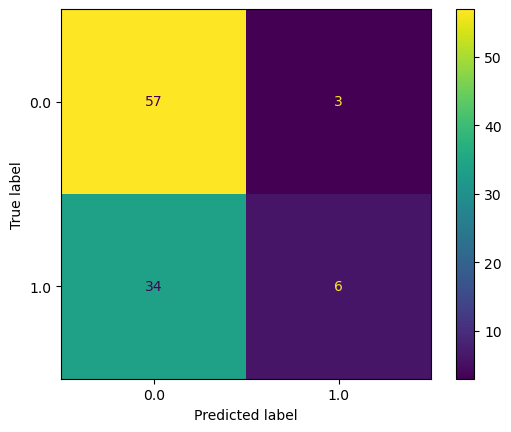

In [96]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

**Beispiele für korrekte Klassifizierungen:**

In [97]:
# Correct predictions
get_correct(predictions)

,Raw sentence,Predicted label,Gold label
1,"Ich nehme kein Beispiel aus dem Bereich des Terrorismus, der Kinderpornografie und auch nicht der Vergewaltigung, sondern ich nehme ein sehr praktisches Beispiel.",0.0,0.0
2,"Da die Zuwanderer solche familiären Netzwerke hier nicht haben, müssen sie sich auch diesbezüglich neu orientierten.",0.0,0.0
5,"Den Bundesinnenminister als denjenigen zu bezeichnen, der der Integration im Wege stand, heißt wirklich, das, was die Union in den letzten Jahren mit dieser Regierung getan hat, vollkommen zu verleugnen.",0.0,0.0
6,"Wir unterscheiden zwischen jenen, die wegen Krieg und Verfolgung Aussicht auf Asyl haben, und denen, die keine Chance auf eine Zukunft in Deutschland haben.",0.0,0.0
8,Innerhalb von acht Wochen wurden allein 28 000 Asylanträge von Menschen aus dem Kosovo gestellt.,0.0,0.0
...,...,...,...
92,"Dem gleichen Ziel dient die Aufforderung der Financial Action Task Force der OECD, jegliche Terrorismusfinanzierung unter Strafe zu stellen.",0.0,0.0
94,"Habe ich überhaupt eine Chance auf Asyl, wenn ich mein Leben aufs Spiel setze, wenn ich meine Familie, wenn ich meine Kinder verlasse?",0.0,0.0
95,"Auch wenn wir den Bürgerinnen und Bürgern ein Gefühl dafür geben wollen, dass wir mit der außenpolitischen Aufgabe der Bekämpfung der Fluchtursachen verantwortungsvoll umgehen, werden wir ihnen natürlich nicht für jedes Problem eine Lösung servieren können.",0.0,0.0
96,Eine ähnliche Schnittstellenfunktion erfüllt der Generalbundesanwalt beim Thema islamistischer Terrorismus.,0.0,0.0


**Beispiele für falsche Klassifizierungen:**

In [98]:
# Wrong predictions
get_wrong(predictions)

,Raw sentence,Predicted label,Gold label
0,"Solange Menschen keine andere Chance sehen, als über Schlepper und Menschenhändler nach Europa zu kommen, werden wir das Elend an unseren Grenzen nicht los.",0.0,1.0
3,"Aber während wir über unsere Willkommenskultur sprechen, brennen Unterkünfte für Flüchtlinge, werden Anschläge verübt.",0.0,1.0
4,"Nur wenn wir auch in den Herkunftsländern Fluchtursachen bekämpfen und wenn wir Fehlanreize in Deutschland beseitigen, dann werden wir unsere Kommunen dauerhaft und nachhaltig entlasten.",0.0,1.0
7,"Denn wie wollen Sie bitte schön erklären, dass man Syrer nicht nach Ungarn, Italien oder Bulgarien abschieben darf, eritreische oder irakische Flüchtlinge aber schon?",0.0,1.0
9,Einwanderung ist essenziell erforderlich für unsere Gesellschaft.,0.0,1.0
10,"Aber wenn wir das ernst meinen – wir meinen es alle ernst –, dass die Fluchtursachen langfristig nur in den Krisenregionen bekämpft werden können, dann müssen wir uns auch dazu bekennen, dass alle Etats in unserem Haushalt, die sich um die internationale Verantwortung kümmern – humanitäre Hilfe, Polizeiausbildung, wirtschaftliche Zusammenarbeit, aber auch der Etat für Verteidigung –, in den nächsten Jahren deutlicher anwachsen müssen, um dieser Verantwortung gerecht zu werden.",1.0,0.0
11,Damit können und sollen die Fluchtursachen in den wichtigsten Herkunftsländern zusätzlich bekämpft werden.,0.0,1.0
22,"Erst die wirtschaftliche Leistungskraft unseres Landes, gepaart mit soliden Finanzen, erspart uns jetzt schwere Entscheidungen und Konflikte darüber, wie wir die Aufnahme und die Integration so vieler Menschen in Deutschland schaffen und finanzieren wollen.",1.0,0.0
25,Über das novellierte Asylbewerberleistungsgesetz übernimmt der Bund jährlich Kosten von 43 Millionen Euro.,0.0,1.0
29,"Ich bin überzeugt, dass wir beides brauchen: legale Möglichkeiten der Einwanderung und die Verfolgung von gewissenlosen Schleppern.",0.0,1.0


### ***UPDATE MIT NEUEN ANNOTIERTEN DATEN:***

In [99]:
# Best features: unigram counts
y_test, y_pred, orig_test = train_model(new_unigrams_sentiment, new_y, new_orig_indexes, SVC())
predictions = get_predictions(new_raw_sents, y_test, y_pred, orig_test)

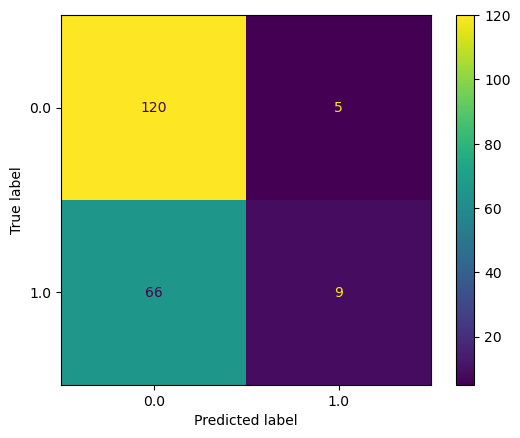

In [100]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

Auch mit mehr Daten ändert sich nicht viel an der Konfusion. Das Modell hat immer noch deutlich mehr Probleme damit, stereotypische Aussagen zu erkennen. Das Modell erkennt in fast 90% der Fälle nicht, dass es sich um eine stereotypische Aussage handelt. Mit den verwendeten Features (Unigramm-Counts + Sentiment) konnte also kein Lerneffekt erzielt werden.

**Beispiele für korrekte Klassifizierungen:**

In [101]:
# Correct predictions
get_correct(predictions)

,Raw sentence,Predicted label,Gold label
1,"Öffnung von Integrations- und Sprachkursen, (Dr.",0.0,0.0
2,"Wer Zukunft, Arbeit und Lebensperspektive für sich sieht, der begibt sich nicht in die Hände von Schleppern.",0.0,0.0
3,"Es ist aber so einfach gesagt, dass Fluchtursachen bekämpft werden müssen.",0.0,0.0
6,"Aber die Auswirkungen der notwendigen Maßnahmen haben auch viele Berührungspunkte mit der Familien-, der Integrations- und der Arbeitsmarktpolitik.",0.0,0.0
9,"Auch wenn wir den Bürgerinnen und Bürgern ein Gefühl dafür geben wollen, dass wir mit der außenpolitischen Aufgabe der Bekämpfung der Fluchtursachen verantwortungsvoll umgehen, werden wir ihnen natürlich nicht für jedes Problem eine Lösung servieren können.",0.0,0.0
...,...,...,...
195,Aus diesem Einwanderungskorridor muss aber dann endlich ein modernes Einwanderungsgesetz wer­ den.,0.0,0.0
196,"Es gibt viele Maßnahmen zur Verbesserung der Versorgung von Asylbewerbern: Impfungen, psy Deutscher Bundestag – 18",0.0,0.0
197,"Dazu gehören viele Dinge, mit denen wir ermöglichen, dass die Integration nicht durch lange Verfahren in Erstaufnahmeeinrichtungen oder anderswo verzögert oder für später erschwert wird.",0.0,0.0
198,Wir können hier nicht über die Lasten der Flüchtlingsaufnahme stöhnen und weiter jeden Elan bei der Bekämpfung der Fluchtursachen vermissen lassen.,0.0,0.0


**Beispiele für falsche Klassifizierungen:**

In [102]:
# Wrong predictions
get_wrong(predictions)

,Raw sentence,Predicted label,Gold label
0,"Denn nur wenn es gelingt, gemeinsam mit der Wirtschaft das Potenzial und die Motivation der Menschen, die zu uns kommen, zu nutzen, nur dann wird Integration gelingen.",0.0,1.0
4,Ein völlig überladenes Schlepperboot mit Flüchtlingen an Bord kenterte auf seinem Weg von Libyen nach Italien.,0.0,1.0
5,"Das Problem ist auch, dass wenige Kilometer davon entfernt an einer Bahnlinie Flächen zur Verfügung stehen, auf denen man Unterkünfte bauen und Asylbewerber unterbringen wollte, aber dann waren sie zu nah an der Bahnlinie, und aus immissionsschutzrechtlichen Gründen war es nicht möglich, dort Unterkünfte zu errichten.",1.0,0.0
7,Damals hatten wir in der Bevölkerung eine geringe Akzeptanz für die Aufnahme von Flüchtlingen und Zuwanderern generell.,0.0,1.0
8,"Nur wenn wir die Fluchtursachen bekämpfen und nur wenn wir die Krisenstaaten stabilisieren, kann uns wirklich die Linderung von Leid gelingen.",0.0,1.0
...,...,...,...
181,"So nachvollziehbar der Wunsch nach einem besseren Leben ist, so richtig ist auch, dass Armut kein Asylgrund ist und dies auch nicht sein kann.",0.0,1.0
188,"Wir sind uns ja bei allen Differenzen über konkrete Punkte in diesem Gesetz einig, dass wir schnellere Asylverfahren brauchen, um schneller zu entscheiden, wer bleiben darf und wer am Ende gehen muss.",0.0,1.0
189,"Das ist ein wichtiges Signal, um denjenigen Tätern, die sich vom Terrorismus abwenden möchten, die Möglichkeit zu geben, ihre Strafe durch die aktive Hilfe zur Aufklärung der Strukturen des Terrorismus zu reduzieren oder gar abzuwenden.",0.0,1.0
191,"Wie wollen Sie denn – aus der Luft auf einen Hafen schauend, in dem sich ein leeres Boot befindet – beurteilen, ob es ein Fischerboot ist, ob es ein Schlepperboot ist oder ob es vielleicht tagsüber ein Fischerboot und nachts ein Schlepperboot ist?",0.0,1.0


**Interpretation: Warum scheitert das Modell in den falschen Beispielen?** 

Ein möglicher Grund dafür, dass so oft fälschlicherwiese Nicht-Stereotype voraus gesagt werden, ist dass es verhältnisweise/im Verhältnis 3:2 mehr Daten für Nicht-Stereotype gibt als für Stereotype. Durch diese Unausgeglichenheit

Laut Sánchez-Junquera et. al. lassen sich Stereotype nicht nur durch die Präsenz spezifischer Wörter erkennen. Das könnte erklären, warum oft ein Nicht-Stereotyp vorhergesagt wird, da die Erkennung von Stereotypen schwieriger ist.

Die falsche Klassifiszierung könnte auch daran liegen, dass Maschinen Schwierigkeiten mit Rhetorischen Mitteln haben. 
Beispiele hierfür sind unter anderem die rhetorische Frage bei 7, oder auch der Sarkasmus in 48. Die rhetorischen Mittel werden nicht erkannt bzw. sind der Maschine unbekannt und werden nicht richtig klassifiziert. Das scheint uns vor allem beim Sarkasmus wahrscheinlich.

Interessanterweise sind die Sätze, die fälschlicherweise als Stereotyp vorhergesagt wurden, oft deutlich länger als der Durchschnitt. Eine mögliche Begründung könnte sein, dass in den längeren Sätzen mehr Features gefunden werden, die dann eher zu Stereotypen passen als zu Nicht-Stereotypen.


## Assoziation zwischen Ngrammen und Labels
Sánchez-Junquera et al. argumentieren, dass Stereotype nicht nur in Form von Zuschreibungen negativer Attribute einer Personengruppe auftreten, sondern oft deutlich subtiler sind. Vielmehr zeichnen sich Stereotype durch das Framing, also durch das Narrativ und den Kontext, in welches die jeweilige Personengruppe platziert wird, aus. Indem das Framing von Migration/Migrant\*innen annotiert wird, sollen auch diejenigen Aussagen über Migrant\*innen, welche nicht auf den ersten Blick als stereotypisch erkennbar sind, identifiziert werden. 

Die Autor\*innen des Papers kommen auf einen interessanten Ansatz, in dem die Bereicherung der Sozialwissenschaften durch komputationelle Verfahren sichtbar wird. Sie berechnen für alle Ngramme (Bi- und Trigramme) den **PMI (Pointwise Mutual Information)** zu den jeweiligen Labels (also "Stereotype vs. Nonstereotype" bzw. "Victims vs. Threats"). PMI ist ein statistisches Maß, welches die Assoziation zwischen Ereignissen misst. Mit anderen Worten:  Zum einen untersuchen die Autor\*innen, welche Ngramme  am stärksten mit stereotypischen bzw. nicht-stereotypischen Aussagen assoziert sind. Zum anderen untersuchen sie welche Ngramme am stärksten mit pro-migrantischen Aussagen, welche Migrant\*innen als Opfer framen, assoziiert sind und welche Ngramme am stärksten mit anti-migrantischen Aussagen, in denen Migrant\*innen als Bedrohung dargestellt werden, assoziiert sind.
Ziel dabei ist, subtilere, nicht-triviale linguistische Muster automatisch zu ermitteln, welche zwar stark mit Stereotypen bzw. einer bestimmten Ausprägung von Stereotypen verbunden (also oft gleichzeitig mit ihnen auftreten), jedoch nicht für uns als solche ersichtlich sind.

Das wollen wir ebenfalls nachbilden.

**Wahrscheinlichkeit von Ngrammen berechnen:**

In [103]:
# Counts of total occurrences of ngrams
def count_ngrams(ngrams, ngram_count_matrx):
    """Count total occurrence of all ngrams appearing in the data"""
    ngram_counts = dict()
    for i, ngram in enumerate(ngrams):
        ngram_counts[ngram] = np.sum(ngram_count_matrx, axis=0)[i]
    return ngram_counts

# Get total number of ngrams
def get_total_count(ngram_counts):
    """Get total count of all ngrams combined"""
    return sum(ngram_counts.values())

In [104]:
unigram_counts = count_ngrams(unigrams, unigram_count_matrx)
bigram_counts = count_ngrams(bigrams, bigram_count_matrx)
trigram_counts = count_ngrams(trigrams, trigram_count_matrx)

N_unigrams = get_total_count(unigram_counts)
N_bigrams = get_total_count(bigram_counts)
N_trigrams = get_total_count(trigram_counts)

In [105]:
# Compute ngram probability
def get_prob(ngram, ngram_counts, N_ngrams):
    """Return the probability that an ngram appears in the data"""
    return ngram_counts.get(ngram) / N_ngrams

**Beispiel:** Wahrscheinlichkeit von "terrorismus"

In [106]:
# Probability of occurrence of "terrorismus"
print("Probability of 'terrorismus':")
get_prob("terrorismus", unigram_counts, N_unigrams)

Probability of 'terrorismus':


0.005653021442495127

**Wahrscheinlichkeit der Kookkurrenz von Ngrammen und Labels berechnen:**

In [107]:
# Counts of cooccurrence of ngrams and labels
def count_ngram_label_cooccurrence(ngrams, ngram_count_matrx):
    """Count the cooccurrence of ngrams and labels"""
    ngram_label_cooccurrence = dict()
    for i in range(sents.size):
        for j in range(ngrams.size):
            tpl = (ngrams[j], y[i])
            if tpl in ngram_label_cooccurrence.keys():
                ngram_label_cooccurrence[tpl] += ngram_count_matrx[i, j]
            else:    
                ngram_label_cooccurrence[tpl] = ngram_count_matrx[i, j]
    return ngram_label_cooccurrence

In [108]:
unigram_label_coocc = count_ngram_label_cooccurrence(unigrams, unigram_count_matrx)
bigram_label_coocc = count_ngram_label_cooccurrence(bigrams, bigram_count_matrx)
trigram_label_coocc = count_ngram_label_cooccurrence(trigrams, trigram_count_matrx)

In [109]:
# Compute probability of cooccurrence of ngram and label
def get_coocc_prob(ngram, label, ngram_label_coocc, ngram_counts):
    """Return probability that an ngram cooccurrs with the specified label"""
    return ngram_label_coocc.get((ngram, label)) / ngram_counts.get(ngram)

**Beispiel:** Wahrscheinlichkeit, dass "terrorismus" mit Label "0" bzw. Label "1" auftritt

In [110]:
# Probability of cooccurrence of "terrorismus" and label 0 (Contains no stereotypes)
print("Probability of 'terrorismus' occurring in sentence with label 0:")
get_coocc_prob("terrorismus", 0, unigram_label_coocc, unigram_counts)

Probability of 'terrorismus' occurring in sentence with label 0:


0.5862068965517241

In [111]:
# Example: Probability of cooccurrence of "terrorismus" and label 1 (Contains stereotypes)
print("Probability of 'terrorismus' occurring in sentence with label 1:")
get_coocc_prob("terrorismus", 1, unigram_label_coocc, unigram_counts)

Probability of 'terrorismus' occurring in sentence with label 1:


0.41379310344827586

**Berechnung der Pointwise Mutual Information (PMI):**

In [112]:
# Compute pmi (pointwise mutual information) of ngrams to each label
def get_ngram_label_pmi(ngram_label_coocc, ngram_counts, ngrams_total):
    """
    Computes the pmi for an ngram and labels 0 and 1 according to following formula:
    pmi(a, b) = log[P(a,b) / (P(a)*P(b))]
    """
    pmi_0, pmi_1 = dict(), dict()
    # Note: We're assuming that the probability of the labels are both 0.5 
    # (like Sánchez-Junquera et. al.)
    p_label = 0.5
    for ngram, label in ngram_label_coocc.keys():
        p_ngram_label_coocc = get_coocc_prob(ngram, label, ngram_label_coocc, ngram_counts)
        p_ngram = get_prob(ngram, ngram_counts, ngrams_total)
        quot = p_ngram_label_coocc / (p_ngram * p_label)
        pmi = 0 if quot == 0 else log(quot)
        if label == 0:
            pmi_0[ngram] = pmi
        else:
            pmi_1[ngram] = pmi
            
    # Sort ngrams according to pmi
    sorted_pmi_0 = sorted(pmi_0.items(), key=lambda x: x[1], reverse=True)
    sorted_pmi_1 = sorted(pmi_1.items(), key=lambda x: x[1], reverse=True)
    
    return sorted_pmi_0, sorted_pmi_1

In [113]:
unigrams_0_pmi, unigrams_1_pmi = get_ngram_label_pmi(unigram_label_coocc, unigram_counts, N_unigrams)
bigrams_0_pmi, bigrams_1_pmi = get_ngram_label_pmi(bigram_label_coocc, bigram_counts, N_bigrams)
trigrams_0_pmi, trigrams_1_pmi = get_ngram_label_pmi(trigram_label_coocc, trigram_counts, N_trigrams)

### ***UPDATE MIT NEUEN ANNOTIERTEN DATEN:***

In [114]:
new_unigram_counts = count_ngrams(new_unigrams, new_unigram_count_matrx)
new_bigram_counts = count_ngrams(new_bigrams, new_bigram_count_matrx)
new_trigram_counts = count_ngrams(new_trigrams, new_trigram_count_matrx)

new_N_unigrams = get_total_count(new_unigram_counts)
new_N_bigrams = get_total_count(new_bigram_counts)
new_N_trigrams = get_total_count(new_trigram_counts)

In [115]:
new_unigram_label_coocc = count_ngram_label_cooccurrence(new_unigrams, new_unigram_count_matrx)
new_bigram_label_coocc = count_ngram_label_cooccurrence(new_bigrams, new_bigram_count_matrx)
new_trigram_label_coocc = count_ngram_label_cooccurrence(new_trigrams, new_trigram_count_matrx)

In [116]:
new_unigrams_0_pmi, new_unigrams_1_pmi = get_ngram_label_pmi(new_unigram_label_coocc, new_unigram_counts, new_N_unigrams)
new_bigrams_0_pmi, new_bigrams_1_pmi = get_ngram_label_pmi(new_bigram_label_coocc, new_bigram_counts, new_N_bigrams)
new_trigrams_0_pmi, new_trigrams_1_pmi = get_ngram_label_pmi(new_trigram_label_coocc, new_trigram_counts, new_N_trigrams)

### Ergebnisse

**Bigramme, die am stärksten mit unstereotypischen Sätzen assoziiert sind:**

In [117]:
print("Bigrams most associated with label 0:")
bigrams_0_pmi[:10]

Bigrams most associated with label 0:


[('abgegeben notwendig', 9.133459327640225),
 ('abgegrenzt flüchtlinge', 9.133459327640225),
 ('abgelehnt wurde', 9.133459327640225),
 ('abgelehnte asylbewerber', 9.133459327640225),
 ('abgeschlossenen asylverfahren', 9.133459327640225),
 ('abgesprochen deren', 9.133459327640225),
 ('abriegeln weder', 9.133459327640225),
 ('absatz strafbarkeit', 9.133459327640225),
 ('abschaffen beibehalten', 9.133459327640225),
 ('abschieben abschrecken', 9.133459327640225)]

**Bigramme, die am stärksten mit stereotypischen Sätzen assoziiert sind:**

In [118]:
print("Bigrams most associated with label 1:")
bigrams_1_pmi[:10]

Bigrams most associated with label 1:


[('abgeordneten bündnisses', 9.133459327640225),
 ('abgestattet islamistischen', 9.133459327640225),
 ('abgleiten landes', 9.133459327640225),
 ('abgrenzung ausgrenzung', 9.133459327640225),
 ('ablehnen parallelgesellschaften', 9.133459327640225),
 ('abrede stellen', 9.133459327640225),
 ('absage erteilen', 9.133459327640225),
 ('abschaffung asylbewerberleistungsgesetzes', 9.133459327640225),
 ('abschieben darf', 9.133459327640225),
 ('abschieben finde', 9.133459327640225)]

### ***UPDATE MIT NEUEN ANNOTIERTEN DATEN:***

In [119]:
print("Bigrams most associated with label 0:")
new_bigrams_0_pmi[:10]

Bigrams most associated with label 0:


[('abgegeben notwendig', 9.831991550831058),
 ('abgegrenzt flüchtlinge', 9.831991550831058),
 ('abgelehnt wurde', 9.831991550831058),
 ('abgeschlossenen asylverfahren', 9.831991550831058),
 ('abgesprochen deren', 9.831991550831058),
 ('abriegeln weder', 9.831991550831058),
 ('absatz strafbarkeit', 9.831991550831058),
 ('abschaffen beibehalten', 9.831991550831058),
 ('abschieben abschrecken', 9.831991550831058),
 ('abschiebung länder', 9.831991550831058)]

In [120]:
print("Bigrams most associated with label 1:")
new_bigrams_1_pmi[:10]

Bigrams most associated with label 1:


[('abgeordneten bündnisses', 9.831991550831058),
 ('abgestattet islamistischen', 9.831991550831058),
 ('abgleiten landes', 9.831991550831058),
 ('abgrenzung ausgrenzung', 9.831991550831058),
 ('ablehnen parallelgesellschaften', 9.831991550831058),
 ('abrede stellen', 9.831991550831058),
 ('absage erteilen', 9.831991550831058),
 ('abschieben darf', 9.831991550831058),
 ('abschieben finde', 9.831991550831058),
 ('abschiebung land', 9.831991550831058)]

### Interpretation
Aus der Liste von Bigrammen, die am stärksten mit Aussagen ohne Stereotype assoziiert sind, kann man eher wenig Information herausziehen. Bigramme wie "abgegrenzt flüchtlinge" oder "abschieben abschrecken" sind überraschend. Rein intuitiv und vielleicht ein wenig mit Weltwissen würden wir vermuten solche Bigramme in einem Kontext vorzufinden, in dem zum Beispiel die Asylpolitik kritisiert wird. Zumindest sind diese Bigramme nicht neutral. 
Betrachtet man die Bigramme, die am stärksten mit stereotypischen Aussagen assoziiert sind, zeigen sich ebenfalls Bigramme, die man nicht ganz klar nachvollziehen kann (z.B. "abgeordneten bündnisses"). 

Einige Bigramme nehmen wir allerdings auch als recht plausibel wahr. Ein Beispiel ist das Bigramm "abgestattet islamistischen". Das häufige Aufbringen von Islamismus im Zusammenhang mit Geflüchteten oder Migrant\*innen in rechtspopulistischen, anti-migrantischen Diskursen, die sich vor allem stereotypischen Bildern bedienen, ist bekannt. Auch, dass "ablehnen parallelgesellschaften" in der Liste auftaucht, erscheint plausibel. Ein stereotypisches Bild, welches oft gezeichnet wird, ist das der Migrant\*innen, die sich in Deutschland eine "Parallelgesellschaft" aufbauen, ohne den Willen sich in in die deutsche Gesellschaft zu integrieren. 

Insgesamt findet man jedoch nur punktuell Bigramme, welche sich klar mit unserer menschlichen Intuition vereinbaren lassen. Sánchez-Junquera et al. sehen das in ihrem Paper als Indiz dafür, dass Stereotype sich nicht trivialerweise und intuitiv sprachlich charakterisieren lassen und argumentieren, dass komputationelle Verfahren deshalb interessante Erkenntnisse liefern können. Für unsere Studie wäre diese Schlussfolgerung deutlich zu weit hergeholt. Die sehr begrenzte Datenmenge lässt keine überzeugende Verallgemeinerung zu. Viele der Bigramme tauchen vermutlich alleinig aufgrund ihrer schieren Frequenz in den Listen auf und nicht, weil sie semantisch mit Stereotypen bzw. nicht mit Stereotypen assoziiert sind.

Die Listen haben sich mit den neuen annotierten Daten nicht großartig verändert. In der Liste der mit stereotypischen Aussagen assoziierten Bigramme ist nun ('abschaffung asylbewerberleistungsgesetzes') verschwunden. Das ist möglicherweise dadurch erklärbar, dass durch die größere Datenmenge nun sehr spezifische Bigramme, welche vorher zufällig viel Gewicht hatten nun an Bedeutung verloren haben. Ansonsten bleibt es jedoch bei der obigen Auswertung.

## 2. Aufgabe: Opfer vs. Bedrohung
Bei diesem Experiment geht es darum herauszufinden, ob das Modell es schafft, die Dimensionen der Stereotype von Aussagen richtig zu klassfizieren. Das Augenmerk von Sánchez-Junquera et al. liegt hierbei insbesondere auf Aussagen, welche zwar als anti-migrantisch zu definieren sind, jedoch durch rhetorische Mittel von Politiker\*innen als solche unkenntlich gemacht werden. Menschliche Annotator\*innen schaffen es (in den meisten Fällen), solche Aussagen richtig einzuordnen. Die Frage ist, ob die getesteten Modelle auch dazu in der Lage sind.

Für diese Aufgabe erstellen wir einen Teil-Datensatz bestehend aus allen Aussagen, denen von den Annotator\*innen ein Frame oder eine Kategorie zugeordnet wurde. Sánchez-Junquera et al. definieren die Suprakategorie "Opfer" als die Vereinigung von Kategorien 1 ("Opfer von Xenophobie") und Kategorie 2 ("Leidende Opfer") sowie die Suprakategorie "Bedrohung" als die Vereinigung von Kategorie 4 ("Gefahr für das Kollektiv"), Kategorie 5 ("Gefahr für Einzelne") und Kategorie 6 ("Entmenschlichung"). Kategorien 4 und 5 haben wir zusammengefasst, Kategorie 6 aufgrund fehlender Daten ausgeschlossen. Kategorie 3 ("Ökonomische Ressource") wurde für dieses Experiment von Sánchez-Junquera et al. exkludiert, da zu wenig Daten vorlagen. Aus demselben Grund entschieden auch wir uns dazu, diese Kategorie nicht einzubeziehen. 
Letzendlich erhielten also alle Aussagen mit einem Frame < 3 das Label "1" für "Opfer" und alle Aussagen mit einem Frame > 3 das Label "0" für "Bedrohung.

In [51]:
# Create subset with all sentences containing stereotypes
stereotypes_df = raw_df.loc[raw_df["Frame"] != "x"].copy()

# Convert to float
stereotypes_df["Frame"] = stereotypes_df["Frame"].astype("float")

# Add binary goldlabels for classification task
stereotypes_df.loc[stereotypes_df["Frame"] < 3, "Victim"] = 1
stereotypes_df.loc[stereotypes_df["Frame"] > 3, "Victim"] = 0

In [52]:
# Examine the size of the new dataset
stereotypes_df.shape

(198, 5)

In [53]:
# Number of sentences where immigrants are framed as threats
sum(stereotypes_df["Victim"] == 0)

54

In [54]:
# Number of sentences in category 3 ("economic resource") 
stereotypes_df["Victim"].isnull().sum()

16

In [55]:
# Remove category 3
stereotypes_df.dropna(axis=0, inplace=True)
stereotypes_df.head()

,Term_NDoc_Date,Sentence,Frame,Contains stereotypes,Victim
2,18_100_2015-04-23,"Berlin, Donnerstag, den 23. April 2015 9485 Dr. Dietmar Bartsch (A) (C) (D)(B) bereitstellen – auch in Kenntnis der Tatsache, dass die Übergriffe auf Ausländer, auf Unterkünfte der Asylbewerber zugenommen haben und dass Menschen, die im Ehrenamt diese Willkommenskultur, von der wir alle sprechen, leben, eben nicht wenige Probleme haben.",2.1,1.0,1.0
3,18_100_2015-04-23,"Es ist überhaupt nicht hinnehmbar, wenn der Generalsekretär einer immerhin regierungstragenden Partei, der CSU, sagt, das Asylrecht sei nicht für Sozialtouristen gemacht, die einen Freifahrtschein ins „All-inclusive-Sozialparadies“ buchen wollen.",4.4,1.0,0.0
4,18_100_2015-04-23,"Denn auch unter dem Gesichtspunkt – Kollege Bartsch hat auf die Flüchtlingsströme hingewiesen –, dass wir in den nächsten Jahren große Anstrengungen unternehmen müssen, um Flüchtlinge aufzunehmen und zu integrieren – Integration ist fast genauso wichtig –, muss die Leistungsbereitschaft der Kommunen gewährleistet sein.",4.1,1.0,0.0
11,18_100_2015-04-23,"Die Mehrheit der deutschen Bevölkerung steht beispielhaft zu unserer Willkommenskultur, indem sie vor Ort auf vielfältige Weise die Ankunft und das Leben der Flüchtlinge begleitet und erleichtert.",1.5,1.0,1.0
12,18_100_2015-04-23,"Kolleginnen und Kollegen, das Recht auf Asyl ist und bleibt unantastbar.",1.1,1.0,1.0


In [56]:
# Get goldlabels
y = stereotypes_df["Victim"].to_numpy()

### Klassenverteilung
Aus den 198 Sätzen mit Stereotyp erhalten wir 128 Sätze, die mit Kategorien annotiert wurden und welche der Suprakategorie "Opfer" angehören Davon sind 39 aus Kategorie 1: Opfer von Xenophobie und 89 aus Kategorie 2: Leidende Opfer. 54 Sätze gehören zur Suprakategorie "Bedrohung". Diese besteht nur aus den Sätzen von Kategorie 4. Wie bereits erwähnt wurden die 16 Sätze aus Kategorie 3 nicht mit betrachtet, da es zu wenig Daten gibt. Es ist auffällig, dass es mehr als doppelt so viele Sätze in der "Opfer" Suprakategorie gibt als in der "Bedrohung" Suprakategorie".

In [57]:
# Number of sentences where immigrants are labeled as victims
sum(stereotypes_df["Victim"] == 1)

128

In [58]:
# Number of sentences where immigrants are labeled as threats
sum(stereotypes_df["Victim"] == 0)

54

### Preprocessing
Wie auch bei der ersten Aufgabe werden beim Preprocessing die Sätze tokenisiert, die Groß- und Kleinschreibung vereinheitlicht und Stoppwörter und Punktuation entfernt.

In [59]:
# Preprocess sentences 
raw_sents = stereotypes_df["Sentence"].to_numpy()
sents = apply_preprocessing(raw_sents)
sents.size

182

In [60]:
# Array with original indexes so we can retrieve raw sentences later
orig_indexes = np.arange(raw_sents.size)
orig_indexes.size

182

### Extraktion von Features für überwachtes Lernen

In [61]:
# Get ngram counts
unigrams, unigram_count_matrx = get_ngram_count_matrx(sents, 1)
bigrams, bigram_count_matrx = get_ngram_count_matrx(sents, 2)
trigrams, trigram_count_matrx = get_ngram_count_matrx(sents, 3)

unigrams.size, bigrams.size, trigrams.size

(1278, 1844, 1719)

In [62]:
# Get ngram counts with tfidf weights
unigram_tfidf_matrx = transform_to_tfidf(unigram_count_matrx)
bigram_tfidf_matrx = transform_to_tfidf(bigram_count_matrx)
trigram_tfidf_matrx = transform_to_tfidf(trigram_count_matrx)

unigram_tfidf_matrx.shape, bigram_tfidf_matrx.shape, trigram_tfidf_matrx.shape

((182, 1278), (182, 1844), (182, 1719))

In [63]:
# Get sentiment scores
sentiment_scores = get_sentiment(sents).reshape(-1, 1)
sentiment_scores.shape

(182, 1)

In [64]:
# Create dicts with features
name2ngram_counts = {
    "Unigram counts": unigram_count_matrx,
    "Bigram counts": bigram_count_matrx, 
    "Trigram counts": trigram_count_matrx
}
name2ngram_tfidf = {
    "Unigram Tfidf": unigram_tfidf_matrx,
    "Bigram Tfidf": bigram_tfidf_matrx,
    "Trigram Tfidf": trigram_tfidf_matrx
}

### Ergebnisse

**1. Bag-of-ngrams ohne Tfidf-Gewichtung:**

Alle Modelle schneiden mit einer Accuracy von 0.7 und dem Macro F1 score von 0.41 gleich gut ab. Der F1 Score für Kategorie 0 (Bedrohungen) liegt bei 0. Das zeigt dass Kategorie 0 nicht vorhergesagt wurde.

Die Baseline wurde mit jedem Modell geschlagen.

In [65]:
print_results(name2ngram_counts)

Unigram counts:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        11
         1.0       0.70      1.00      0.83        26

    accuracy                           0.70        37
   macro avg       0.35      0.50      0.41        37
weighted avg       0.49      0.70      0.58        37



Bigram counts:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        11
         1.0       0.70      1.00      0.83        26

    accuracy                           0.70        37
   macro avg       0.35      0.50      0.41        37
weighted avg       0.49      0.70      0.58        37



Trigram counts:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        11
         1.0       0.70      1.00      0.83        26

    accuracy                           0.70        37
   macro avg       0.35      0.50      0.41        37
weighted avg       0.49

**2. Bag-of-ngrams mit Tfidf-Gewichtung:**

Bei den Modellen mit tfidf-Gewichtung schneiden alle Modelle genauso gut ab wie bei den Modellen ohne tfidf-Gewichtung. 

In [66]:
print_results(name2ngram_tfidf)

Unigram Tfidf:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        11
         1.0       0.70      1.00      0.83        26

    accuracy                           0.70        37
   macro avg       0.35      0.50      0.41        37
weighted avg       0.49      0.70      0.58        37



Bigram Tfidf:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        11
         1.0       0.70      1.00      0.83        26

    accuracy                           0.70        37
   macro avg       0.35      0.50      0.41        37
weighted avg       0.49      0.70      0.58        37



Trigram Tfidf:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        11
         1.0       0.70      1.00      0.83        26

    accuracy                           0.70        37
   macro avg       0.35      0.50      0.41        37
weighted avg       0.49   

**3. Sentiment:**

Das Modell mit Sentiment erreicht ebenfalls eine Accuracy von 0.7 und ein Macro F1 score von 0.41. Dadurch wird auch hier die Baseline geschlagen. 

In [67]:
y_test, y_pred, orig_test = train_model(sentiment_scores, y, orig_indexes, SVC())
predictions = get_predictions(y_test, y_pred, orig_test)
print("Sentiment:")
print(classification_report(y_test, y_pred, zero_division=0))

Sentiment:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        11
         1.0       0.70      1.00      0.83        26

    accuracy                           0.70        37
   macro avg       0.35      0.50      0.41        37
weighted avg       0.49      0.70      0.58        37



### Ergebnisse genauer betrachten:
Wir schauen uns die Ergebnisse des besten Modells an, um detailliertere Einblicke zu erhalten.

**Konfusionsmatrix:** 

Es ist auffällig, dass gar keine Vorhersagen zur Suprakategorie Bedrohung gemacht werden. Die Daten für Experiment 2 sind unausgeglichener als die für Experiment 1, d.h. es besteht ein ungefähres Verhältnis von 2:1 für Opfer zu Bedrohung bei Experiment 2. Im Vergleich dazu ist das ungefähre Verhältnis 3:2 für Nicht-Stereotype zu Stereotype bei Experiment 1. Deshalb gehen wir davon aus, dass durch die unausgeglichene Daten kombiniert mit der geringeren Datenmenge das Modell nicht lernen konnte, was die Kategorie Bedrohung ausmacht.
Wie auch Sánchez-Junquera et. al. kommen wir zu dem Schluss, dass die geringere Größe des Trainingsets einen Einfluss auf die Ergebnisse von Experiment 2 hat. 

Sánchez-Junquera et. al. vermuten, dass die Konfusion des Models darauf beruht, dass in der Politik die gleichen Worte für verschiedene Zwecke verwendet werdem, um nicht als xenophob bezeichnet zu werden. Das erscheint uns plausibel, und könnte eine Begründung sein, warum für Bedrohung keine Sätze gefunden wurden.

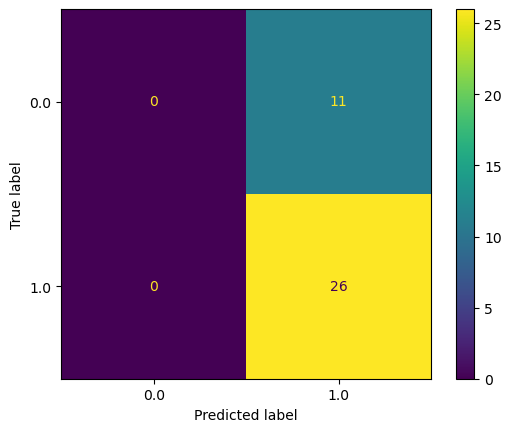

In [68]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

## Evaluation: Bei welchem Experiment ist Performanz besser?
Bei Experiment 2 ist die Accuracy mit 0.7 bei jedem Modell deutlich höher als beim besten Ergebnis von Experiment 1,  welches eine Accuracy von 0.63 hat. Allerdings ist der Marco F1 score von Experiment 2 mit 0.41 schlechter als der Macro F1 von 0.5 beim besten Model von Experiment 1. Die höhere Accuracy mit geringerem F1 score könnte daran liegen, dass durch die verschiedenen unbalancierten Daten eine majority baseline nachgebildet wird: je größer die Majority Class ist, desto höher ist auch die Accuracy wenn nur oder größenteils die Majority Class vorhergesagt wird. 

Insgesamt schätzen wir ein, dass Experiment 1 die bessere Performance hat. Das wird vor allem bei der Betrachtung der F1 scores deutlich.

## Anmerkung:

Beim ersten Experiment hat sich bereits folgendes deutlich abgezeichnet: Ein solch (nicht nur) linguistisch komplexes Problem lässt sich nicht mit einem einfachen linearen Klassifikationsmodell, z.B. einer Support-Vector-Machine lösen. Auch ein Datensatz von 1000 Sätzen im Vergleich zu 500 Sätzen bewirkt keinen signifikanten Unterschied. Aus diesem Grund haben wir von der weiteren Reevaluation des zweiten Experimentes (Opfer vs. Bedrohung) mit den neuen annotierten Daten abgesehen. 

## Fazit und Diskussion
Sánchez-Junquera et al. vergleichen in ihrem Paper klassische ML-Modelle, welche durch relativ triviale lexikalische Features trainiert wurden, mit komplexeren SOA-Transformermodellen. Bei der  ersten Klassifikationsaufgabe ("Stereotype vs. Nonstereotype") sind die klassischen ML-Modelle den komplexeren Transformermodellen weit unterlegen. Beim zweiten Experiment ("Victims vs. Threats") ist es umgekehrt. Die Autor\*innen vermuten, dass komplexere Transformermodelle aufgrund der komplexen Natur der Aufgabe besser geeignet sind. Es herrschen jedoch, insbesondere für die zweite Aufgabe, zu wenig Daten vor, was die bessere Performanz der klassischen ML-Modelle gegenüber den Transformermodellen bei dieser Aufgabe erklären würde. 

Da wir nur mit einem klassischen ML-Modell gearbeitet haben, lässt sich kein Vergleich zu komplexeren Transformermodellen wie bei Sánchez-Junquera et al. herstellen. Es lässt sich dennoch feststellen, dass das Trainieren des Modells mit rein lexikalischen Features definitiv nicht ausreicht, um einen tatsächlichen Lerneffekt, was die linguistischen Muster bezüglich Stereotypen angeht, zu erzielen. Auch die Hinzunahme der Sentimentanalyse brachte keine signifikanten Verbesserungen. Schon bei einem Modell, welches die Sentimentanalyse "perfekt", zumindest der Bewertung genügend menschlicher Annotator\*innen entsprechend, durchführt, wäre es nur spekulativ vermutbar, inwiefern Sentiment und Stereotypisierung eines Satzes zusammenhängen. Bei einem "fehlerhaften" Sentiment-Modell verstärkt sich die Unsicherheit noch enorm.

Die schlechte Performanz bei beiden Aufgaben hängt sehr wahrscheinlich mit dem Mangel an annotierten Trainingsdaten zusammen. Desweiteren wurden die zu annotierenden Sätze für unser Projekt automatisch extrahiert. Sánchez-Junquera et al. hingegen wählten diese manuell aus. Dies könnte ebenfalls einen Faktor für die Diskrepanz der Ergebnisse darstellen.

In zukünftigen Untersuchungen könnte man eventuell mit der Einheit der Annotationen experimentieren. Beide Projekte sind von der Satzebene ausgegangen. Während Sánchez-Junquera et al. sich fragen, ob es eventuell sogar möglich sein sollte, einem Satz mehrere Frames zuzuordnen, haben wir uns die Frage gestellt, ob ein Satz überhaupt genügend Kontext bietet, um ihn adäquat zu annotieren. Der fehlende Kontext eines einzelnen Satzes machte es oft schwer, ihm einem Frame zuzuordnen, zumal diese sehr spezifisch formuliert sind.

Bemerkung: Aufgrund des deutlich kleineren Rahmens unseres Projektes haben wir eine Berechnung des Inter-Annotator-Agreements ausgelassen. Dies wäre aber (zumindest, um einem wissenschaftlichen Anspruch gerecht zu werden) essentiell gewesen, um unseren Ergebnissen Legitimation zu verleihen.